In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MEDIQA-CORR-2024-MS-TrainingData.csv to MEDIQA-CORR-2024-MS-TrainingData.csv


In [ ]:
df = pd.read_csv('MEDIQA-CORR-2024-MS-TrainingData.csv', delimiter=',', encoding='utf-8')
df= df.drop(['Error Sentence ID', 'Error Sentence', 'Corrected Sentence', 'Corrected Text'], axis=1)
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag
0,0,ms-train-0,A 53-year-old man comes to the physician becau...,0 A 53-year-old man comes to the physician bec...,1
1,1,ms-train-1,A 53-year-old man comes to the physician becau...,0 A 53-year-old man comes to the physician bec...,0
2,2,ms-train-2,A 9-year-old girl is brought to the pediatrici...,0 A 9-year-old girl is brought to the pediatri...,1
3,3,ms-train-3,A 9-year-old girl is brought to the pediatrici...,0 A 9-year-old girl is brought to the pediatri...,0
4,4,ms-train-4,Blood cultures are sent to the laboratory. Int...,0 Blood cultures are sent to the laboratory.\n...,1


In [ ]:
import pandas as pd
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Supongamos que df es tu DataFrame con 'Text' y 'Error Flag'
texts = df['Text'].values
labels = df['Error Flag'].values

# Inicializar el tokenizador
tokenizer = TreebankWordTokenizer()

# Función para tokenizar textos
def tokenize_texts(text):
    return ' '.join(tokenizer.tokenize(text))

# Aplicar la tokenización a cada texto
tokenized_texts = [tokenize_texts(text) for text in texts]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(tokenized_texts, labels, test_size=0.3, random_state=42)

# Vectorizar el texto sin eliminar stop words y usando n-gramas de 1 a 3
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 3))
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Entrenar el modelo Random Forest con los parámetros especificados
rf_classifier = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=10,
    max_features='sqrt',
    max_depth=8,
    criterion='entropy',
    random_state=42
)
rf_classifier.fit(X_train_vectors, y_train)

# Predecir las etiquetas para el conjunto de prueba
predictions = rf_classifier.predict(X_test_vectors)

# Predecir las etiquetas para el conjunto de entrenamiento para calcular métricas
predictions_train = rf_classifier.predict(X_train_vectors)

# Calcular métricas para el conjunto de entrenamiento
precision_train = precision_score(y_train, predictions_train, average='macro')
recall_train = recall_score(y_train, predictions_train, average='macro')
f1_train = f1_score(y_train, predictions_train, average='macro')
accuracy_train = accuracy_score(y_train, predictions_train)

# Calcular métricas para el conjunto de prueba
precision_test = precision_score(y_test, predictions, average='macro')
recall_test = recall_score(y_test, predictions, average='macro')
f1_test = f1_score(y_test, predictions, average='macro')
accuracy_test = accuracy_score(y_test, predictions)

# Imprimir las métricas para el conjunto de entrenamiento y prueba
print("TRAIN Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
    accuracy_train, precision_train, recall_train, f1_train))
print("TEST Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
    accuracy_test, precision_test, recall_test, f1_test))

# Evaluar el modelo usando classification_report para el conjunto de prueba
print(classification_report(y_test, predictions))
print(f"Accuracy (Test): {accuracy_test:.4f}")

TRAIN Metrics - Accuracy: 0.5646, Precision: 0.7822, Recall: 0.5007, F1: 0.3622
TEST Metrics - Accuracy: 0.5403, Precision: 0.2702, Recall: 0.5000, F1: 0.3508
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.54      1.00      0.70       355

    accuracy                           0.54       657
   macro avg       0.27      0.50      0.35       657
weighted avg       0.29      0.54      0.38       657

Accuracy (Test): 0.5403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


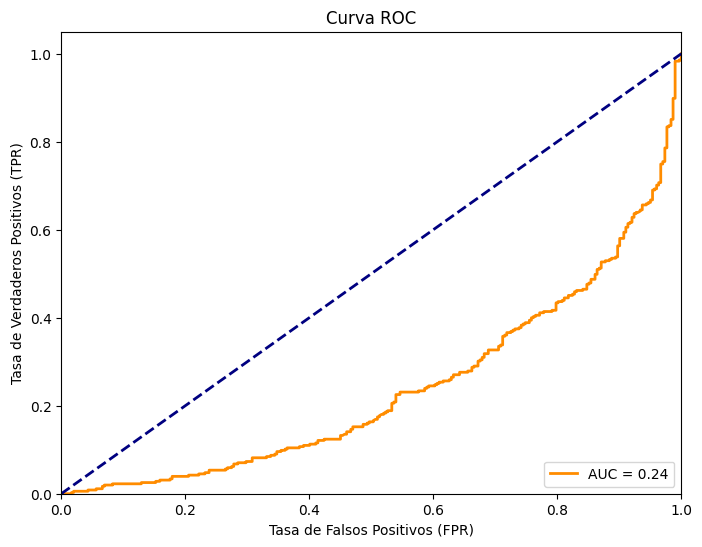

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

probabilities = rf_classifier.predict_proba(X_test_vectors)[:, 1]

# Calcular FPR, TPR, y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Calcular el AUC (Área Bajo la Curva)
auc = roc_auc_score(y_test, probabilities)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import joblib


model_filename = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Random_Forest/rf_classifier_ajust.joblib'
vectorizer_filename = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Random_Forest/tfidf_vectorizer_ajust.joblib'

# Guardar el modelo Random Forest
joblib.dump(rf_classifier, model_filename)

# Guardar el vectorizador TF-IDF
joblib.dump(vectorizer, vectorizer_filename)

['/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/Random_Forest/tfidf_vectorizer_ajust.joblib']